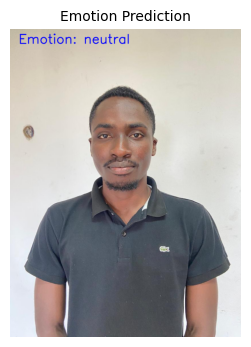

In [18]:
import cv2
import numpy as np
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

# --- Emotion prediction function ---
def predict_emotion(pil_image, coords=None):
    """
    Predict the dominant emotion from a PIL image using DeepFace.
    
    Args:
        pil_image: A PIL Image (whole frame or cropped face).
        coords: (x, y, w, h) tuple for cropping the face region. 
                If None, the whole image is used.
                
    Returns:
        emotion_label: String representing the predicted emotion.
    """
    try:
        if coords:
            x, y, w, h = coords
            pil_image = pil_image.crop((x, y, x + w, y + h))

        img_cv2 = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

        results = DeepFace.analyze(
            img_path=img_cv2,
            actions=['emotion'],
            detector_backend="opencv",
            enforce_detection=False
        )

        emotion_label = results[0]["dominant_emotion"]

    except Exception as e:
        print(f"[Emotion Prediction Error] {e}")
        emotion_label = "neutral"

    return emotion_label

# --- Load the image ---
image_path = "images/Agudey.jpeg"  # replace with your image path
pil_image = Image.open(image_path).convert("RGB")

# --- Predict emotion ---
emotion_label = predict_emotion(pil_image)

# --- Convert to OpenCV format for visualization ---
img_cv2 = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

# --- Overlay text ---
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_cv2, f"Emotion: {emotion_label}", (30, 50),
            font, 1.5, (255, 0, 0), 2, cv2.LINE_AA)

# --- Display inline ---
plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Emotion Prediction", fontsize=10)
plt.show()


Attention Score SHAP


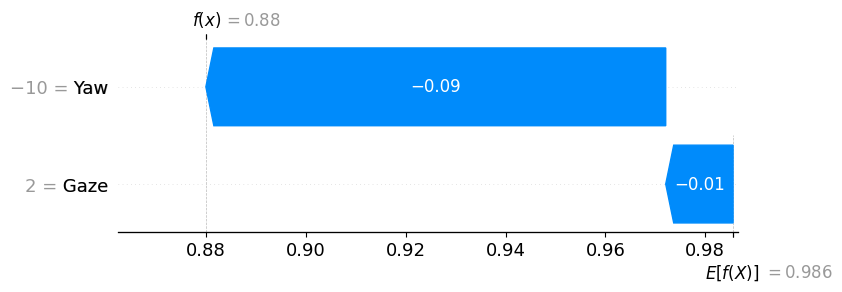

Emotion Score SHAP


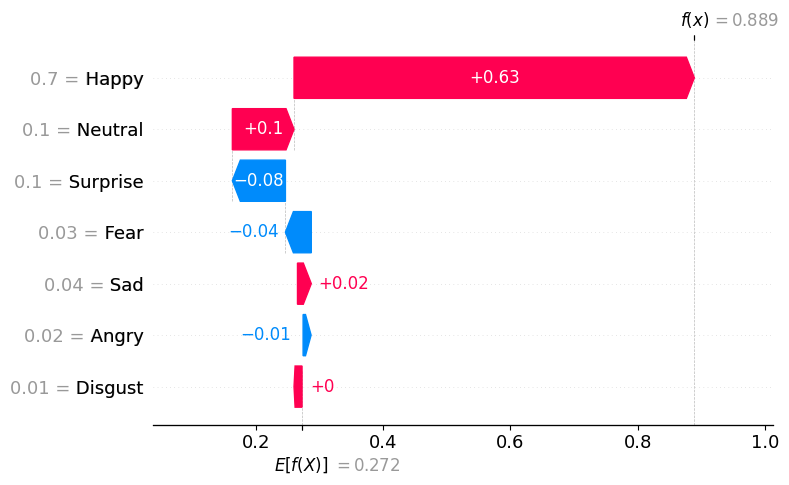

Engagement Score SHAP (Attention + Emotion)


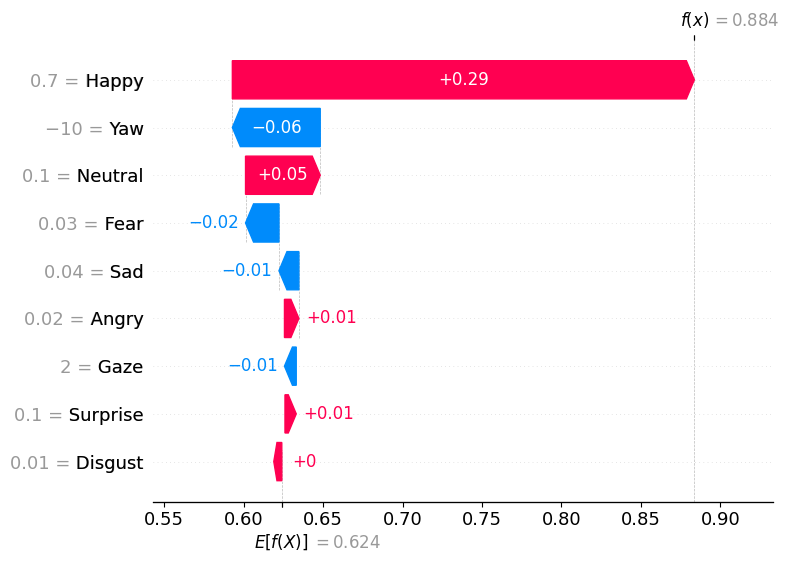

Attention baseline: [0.98556421]
Emotion baseline: [0.27238049]
Engagement baseline: [0.62405018]


In [19]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# --- Example input features (replace with actual EduGaze model outputs) ---
yaw, gaze = -10, 2
emotions = {
    "Happy": 0.7,
    "Surprise": 0.1,
    "Neutral": 0.1,
    "Fear": 0.03,
    "Sad": 0.04,
    "Angry": 0.02,
    "Disgust": 0.01
}

# Convert to array
features_attention = np.array([[yaw, gaze]])
features_emotion = np.array([[list(emotions.values())][0]])
features_engagement = np.array([[yaw, gaze] + list(emotions.values())])

# --- Feature names ---
attention_names = ["Yaw", "Gaze"]
emotion_names = list(emotions.keys())
engagement_names = ["Yaw", "Gaze"] + emotion_names

# --- Model 1: Attention Score ---
def attention_model(X):
    yaw, gaze = X[:, 0], X[:, 1]
    return (100 - abs(yaw) - abs(gaze)) / 100

# --- Model 2: Emotion Score ---
def emotion_model(X):
    happy, surprise, neutral, fear, sad, angry, disgust = X.T
    return (
        happy*1.0 +
        surprise*0.9 +
        neutral*0.7 +
        fear*0.2 +
        sad*0.4 +
        angry*0.3 +
        disgust*0.1
    )

# --- Model 3: Engagement Score ---
def engagement_model(X):
    yaw, gaze = X[:, 0], X[:, 1]
    happy, surprise, neutral, fear, sad, angry, disgust = X[:, 2:].T
    
    attention = (100 - abs(yaw) - abs(gaze)) / 100
    emotion_score = (
        happy*1.0 + 
        surprise*0.9 + 
        neutral*0.7 + 
        fear*0.2 + 
        sad*0.4 + 
        angry*0.3 + 
        disgust*0.1
    )
    return 0.6*attention + 0.4*emotion_score

# --- Background data ---
bg_attention = np.random.normal(0, 1, (50, features_attention.shape[1]))
bg_emotion = np.random.normal(0, 1, (50, features_emotion.shape[1]))
bg_engagement = np.random.normal(0, 1, (50, features_engagement.shape[1]))

# --- SHAP explainers ---
explainer_attention = shap.Explainer(attention_model, bg_attention, feature_names=attention_names)
explainer_emotion = shap.Explainer(emotion_model, bg_emotion, feature_names=emotion_names)
explainer_engagement = shap.Explainer(engagement_model, bg_engagement, feature_names=engagement_names)

# --- Compute SHAP values ---
shap_values_attention = explainer_attention(features_attention)
shap_values_emotion = explainer_emotion(features_emotion)
shap_values_engagement = explainer_engagement(features_engagement)

# --- Plots ---
print("Attention Score SHAP")
shap.waterfall_plot(shap_values_attention[0], show=True)

print("Emotion Score SHAP")
shap.waterfall_plot(shap_values_emotion[0], show=True)

print("Engagement Score SHAP (Attention + Emotion)")
shap.waterfall_plot(shap_values_engagement[0], show=True)

print("Attention baseline:", shap_values_attention.base_values)
print("Emotion baseline:", shap_values_emotion.base_values)
print("Engagement baseline:", shap_values_engagement.base_values)

